In [2]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json

In [3]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York.csv")

In [4]:
df['Year'] = df['Open Date'].str[6:]
df = df.drop(['Fuel Type Code', 'Intersection Directions','Station Phone','Status Code','Owner Type Code',
         'Federal Agency ID','Federal Agency Name','Cards Accepted',
         'EV Network Web','ZIP','Groups With Access Code','Expected Date','Access Days Time',
         'Geocode Status','Updated At','Plus4','Date Last Confirmed',"EV Other Info","Open Date"], axis=1)

In [5]:
df.head()

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,NaN,2.0,NaN,Non-Networked,42.816614,-73.889657,50854,J1772,2021
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,NaN,3.0,NaN,Tesla,40.775496,-73.981552,115044,TESLA,2017
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,NaN,2.0,NaN,ChargePoint Network,41.028410,-73.759380,197206,J1772,2021
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,NaN,2.0,NaN,FLO,40.882337,-73.880265,201636,J1772,2021
4,134 N 4th St,134 N 4th St,Brooklyn,NY,NaN,4.0,NaN,FLO,40.716441,-73.960043,202931,J1772,2021


In [6]:
lista = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
Network = ["Tesla","LIVINGSTON","EV Connect"]

In [7]:
NYC_df = df.query("City in @lista")

In [8]:
NYC_df = NYC_df.query("City not in @esclusione")

In [9]:
NYC_df = NYC_df.query("EV_Network in @Network")

I 4 maggiori Network di ricarica appartengono a Tesla, Livingstone e EV Connect, e non sono compresi in nessun network specifico. Con questi 4 otteniamo circa il 42% della rete. Per semplicità terremo solo le stazioni che fanno parte dei 3 network principali.

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [10]:
NYC_df.index.names = ['Index']
NYC_df = NYC_df.fillna(value=0)
NYC_df.shape

(369, 13)

Il dataset presenta 369 osservazioni, solo relative alla città di New York. 

In [11]:
NYC_df =NYC_df.reset_index(drop=True)

In [12]:
NYC_df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,0.0,3.0,0.0,Tesla,40.775496,-73.981552,115044,TESLA,2017
1,Queens Center - Tesla Supercharger,90-15 Queens Boulevard,Queens,NY,0.0,0.0,10.0,Tesla,40.735082,-73.870670,116809,TESLA,2018
2,Angelina's Ristorante - Tesla,399 Ellis St,Staten Island,NY,0.0,3.0,0.0,Tesla,40.513370,-74.251370,115240,TESLA,2018
3,Parkright 300 E 77th St - Tesla,300 East 77th St,New York,NY,0.0,3.0,0.0,Tesla,40.771689,-73.955816,115085,J1772 TESLA,2016
4,One Blue Slip-Greenpoint - Tesla,1 Blue Slip,Brooklyn,NY,0.0,5.0,0.0,Tesla,40.736224,-73.959356,150540,J1772 TESLA,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,Champion Parking 90 LLC - Tesla,60 E 90th St,New York,NY,0.0,3.0,0.0,Tesla,40.783085,-73.956304,115167,J1772 TESLA,2017
365,Icon Parking E 48th Street - Tesla,329 E 48th St,New York,NY,0.0,3.0,0.0,Tesla,40.753230,-73.967990,115097,J1772 TESLA,2016
366,BNY - Building 6,63 Flushing Ave,Brooklyn,NY,0.0,1.0,0.0,EV Connect,40.699256,-73.969305,230787,J1772,2022
367,Standard Parking Gateway Plaza Garage - Tesla,339 South End Ave,New York,NY,0.0,3.0,0.0,Tesla,40.710652,-74.016396,115102,J1772 TESLA,2017


In [13]:
NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""

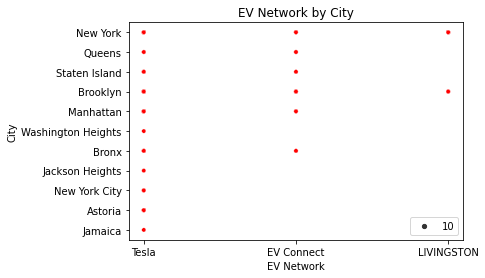

In [14]:
sns.scatterplot(x='EV_Network', y='City', data=NYC_df, size=10, color='red')
plt.title("EV Network by City")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

Plot della mappa

In [15]:
location = NYC_df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10, control_scale=True)

location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["EV_Network"]).add_to(map), axis=1)
map


Calcolo distanza e tempo di guida da una colonnina alla successiva

In [16]:
NYC_df["Distance"],NYC_df["Duration"]="",""

Calcolo della distanza tramite Open Street Map

In [17]:
API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
url = 'http://router.project-osrm.org/route/v1/driving/'

In [18]:
def getDistances(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['distance']/1000 #in km
    else:
        return 0

In [19]:
def getDuration(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['duration']/60 #in min
    else:
        return 0

In [20]:
NYC_df["Next Latitude"] = NYC_df["Latitude"].shift(-1)
NYC_df["Next Longitude"] = NYC_df["Longitude"].shift(-1)
NYC_df["Distance"]  = NYC_df.apply(getDistances, axis = 1)
NYC_df["Duration"]  = NYC_df.apply(getDuration, axis = 1)

In [21]:
NYC_df = NYC_df.loc[NYC_df['Distance'] < 100]
NYC_df = NYC_df.loc[NYC_df['Duration'] < 100]
NYC_df = NYC_df.loc[NYC_df['Distance'] != 0]
NYC_df = NYC_df.loc[NYC_df['Duration'] != 0]

In [22]:
quantiles = NYC_df["Distance"].quantile([0.25, 0.75])
media = NYC_df["Distance"].mean()
minimum = NYC_df["Distance"].min()
maximum = NYC_df["Distance"].max()

print("\nDistance")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles)
print("Media :" + str(media))
print("Minimo :"+str(minimum))
print("Massimo :"+ str(maximum))

quantiles_d= NYC_df["Duration"].quantile([0.25, 0.75])
media_d = NYC_df["Duration"].mean()
minimum_d = NYC_df["Duration"].min()
maximum_d = NYC_df["Duration"].max()
print("\nDuration")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles_d)
print("Media :" + str(media_d))
print("Minimo :"+str(minimum_d))
print("Massimo :"+ str(maximum_d))


Distance

Quantili a 0.25 e 0.75:
0.25     3.9151
0.75    11.7859
Name: Distance, dtype: float64
Media :9.011449180327869
Minimo :0.5006
Massimo :56.9684

Duration

Quantili a 0.25 e 0.75:
0.25     7.041667
0.75    18.097917
Name: Duration, dtype: float64
Media :13.465209471766848
Minimo :1.1033333333333333
Massimo :56.309999999999995


Le distanze tra le colonnine vanno dai circa 0.5km ad un massimo di circa 57km, con una media attorno ai 9km.
Per quanto riguarda il tempo tra una colonnina e l'altro si passa da un minimo di 1 minuto agli oltre 56, con una media di circa 13 minuti e mezzo tra una e l'altra. Qui stiamo prendendo in esame tutte le stazioni, non solo quelle relative ai network Tesla, Livingston ed EV Connect.

In questo modo abbiamo ottenuto la distanza (in miglia) tra una colonnina e la successiva

In [23]:
tesla_df = NYC_df[NYC_df['EV_Network'] =="Tesla"]
evc_df = NYC_df[NYC_df['EV_Network'] =="EV Connect"]
l_df = NYC_df[NYC_df['EV_Network'] =="LIVINGSTON"]

In [24]:
tesla_df = tesla_df.sort_values(by=["City",'Latitude', 'Longitude','Year'])
evc_df = evc_df.sort_values(by=["City",'Latitude', 'Longitude','Year'])
l_df = l_df.sort_values(by=["City",'Latitude', 'Longitude','Year'])

In [25]:
tesla_df["Next Latitude"] = tesla_df["Latitude"].shift(-1)
tesla_df["Next Longitude"] = tesla_df["Longitude"].shift(-1)

In [26]:
evc_df["Next Latitude"] = evc_df["Latitude"].shift(-1)
evc_df["Next Longitude"] = evc_df["Longitude"].shift(-1)

In [27]:
l_df["Next Latitude"] = l_df["Latitude"].shift(-1)
l_df["Next Longitude"] = l_df["Longitude"].shift(-1)

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [28]:
tesla_df =tesla_df.reset_index(drop=True)
evc_df =evc_df.reset_index(drop=True)
l_df =l_df.reset_index(drop=True)

In [29]:
tesla_df["Distance"]  = tesla_df.apply(getDistances, axis = 1)
tesla_df["Duration"]  = tesla_df.apply(getDuration, axis = 1)
evc_df["Distance"]  = evc_df.apply(getDistances, axis = 1)
evc_df["Duration"]  = evc_df.apply(getDuration, axis = 1)
l_df["Distance"]  = l_df.apply(getDistances, axis = 1)
l_df["Duration"]  = l_df.apply(getDuration, axis = 1)

Plot dei grafi divisi per ogni Network

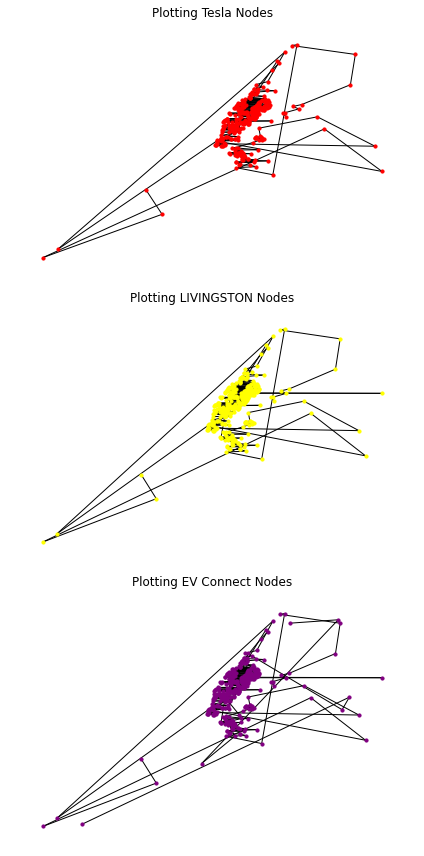

In [33]:
G = nx.Graph()

fig, axs = plt.subplots(3, 1, figsize=(6, 12))
axs = axs.ravel()

data = [(tesla_df, "red", "Plotting Tesla Nodes"),
        (l_df, "yellow", "Plotting LIVINGSTON Nodes"),            
        (evc_df, "purple", "Plotting EV Connect Nodes")]

for idx, (df, color, title) in enumerate(data):
    for i in range(df.shape[0]-1):
        G.add_node(df["ID"][i], pos=(df["Longitude"][i], df["Latitude"][i]))
        # add edge between nodes
        if i > 0:
            G.add_edge(df["ID"][i-1], df["ID"][i])
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=10, node_color=color, ax=axs[idx])
    axs[idx].set_title(title)
    betweenness_centrality = nx.betweenness_centrality(G)
    #closeness
    closeness_centrality = nx.closeness_centrality(G)
    #print("Betweenness centrality for {}: {}".format(title, betweenness_centrality))

    

plt.tight_layout()
plt.savefig("./Graph_city.png", dpi=300)
plt.show()

I 3 grafi disegnati presentano dei tratti molto simili, quasi a voler indicare un unico pattern di poszionamento delle stazioni, come era ovvio aspettarsi la maggior parte sono posizionate nel centro della città, zona ad altissima densità di traffico e solo alcune vengono posizionate in punti periferici come gli accessi all'autostrada e vicino all'aeroporto.

Media di betweenness centrality per Tesla: [0.0]
Media di closeness centrality per Tesla: [0.04282334974871761]

Media di betweenness centrality per Livingston: [0.0]
Media di closeness centrality per Livingston: [0.11478853128603962]

Media di betweenness centrality per EV Connect: [0.0]
Media di closeness centrality per EV Connect: [0.23912298586359612]



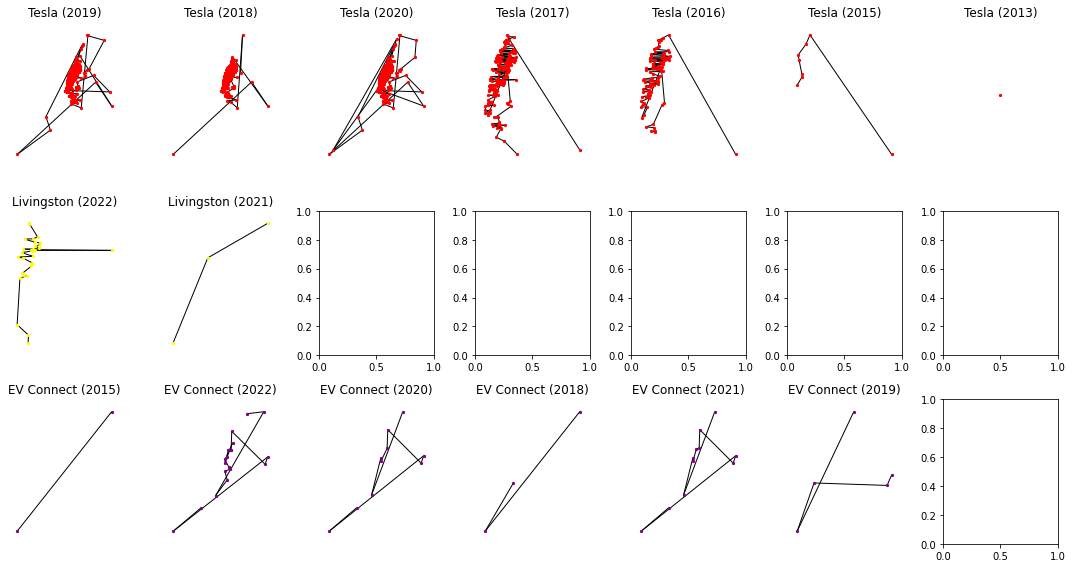

In [34]:
fig, axs = plt.subplots(3, tesla_df["Year"].nunique(), figsize=(15, 8))
data = [(tesla_df, "red", "Tesla"), (l_df, "yellow", "Livingston"), (evc_df, "purple", "EV Connect")]
betweenness_centralities = []
closeness_centralities = []

for i, (df, color, title) in enumerate(data):
    years = df["Year"].unique()
    for j, year in enumerate(years):
        G = nx.Graph()
        year_df = df[df["Year"] <= year].reset_index(drop=True)
        for k in range(year_df.shape[0]):
            pos = (year_df.iloc[k]["Longitude"], year_df.iloc[k]["Latitude"])
            G.add_node(year_df.iloc[k]["ID"], pos=pos)
            if k > 0:
                G.add_edge(year_df.iloc[k-1]["ID"], year_df.iloc[k]["ID"])
        nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=5, node_color=color, ax=axs[i, j])
        axs[i, j].set_title("{} ({})".format(title, year))
        # calcola le misure di centralità
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        
#         print(betweenness)
        betweenness_centralities.append(list(betweenness.values()))
        closeness_centralities.append(list(closeness.values()))

# calcola la media di betweenness e closeness per ogni dataframe
    avg_betweenness = [sum(x)/len(betweenness_centralities) for x in zip(*betweenness_centralities)]
    avg_closeness = [sum(x)/len(closeness_centralities) for x in zip(*closeness_centralities)]

    print("Media di betweenness centrality per {}: {}".format(title, avg_betweenness))
    print("Media di closeness centrality per {}: {}\n".format(title, avg_closeness))

plt.tight_layout()
plt.savefig("./Graph_city.png", dpi=300)
plt.show()


In [35]:
tesla_df.shape

(317, 17)

In [36]:
l_df.shape

(30, 17)

In [37]:
evc_df.shape

(19, 17)